In [15]:
pip install tf-keras-vis

     -------------------------------------- 52.5/52.5 kB 450.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aggdraw                       1.3.18.post0
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
audioread                     3.0.1
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1


In [21]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import BatchNormalization , GRU
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from keras.utils import plot_model
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf

In [2]:
ravdess = "RAVDESS Emotional speech audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)
Crema = "CREMA-D/AudioWAV/" # audios with different emotions
Tess = "Toronto emotional speech set (TESS)/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "Surrey Audio-Visual Expressed Emotion (SAVEE)/ALL/"

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [4]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

  Emotions                                               Path
0  neutral  RAVDESS Emotional speech audio/audio_speech_ac...
1  neutral  RAVDESS Emotional speech audio/audio_speech_ac...
2  neutral  RAVDESS Emotional speech audio/audio_speech_ac...
3  neutral  RAVDESS Emotional speech audio/audio_speech_ac...
4  neutral  RAVDESS Emotional speech audio/audio_speech_ac...
______________________________________________
      Emotions                                               Path
1435  surprise  RAVDESS Emotional speech audio/audio_speech_ac...
1436  surprise  RAVDESS Emotional speech audio/audio_speech_ac...
1437  surprise  RAVDESS Emotional speech audio/audio_speech_ac...
1438  surprise  RAVDESS Emotional speech audio/audio_speech_ac...
1439  surprise  RAVDESS Emotional speech audio/audio_speech_ac...
_______________________________________________
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: Emotions, dtype: in

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: Emotions, dtype: int64


In [6]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: Emotions, dtype: int64


In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: Emotions, dtype: int64


In [8]:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
1,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
2,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
3,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
4,neutral,RAVDESS Emotional speech audio/audio_speech_ac...


In [9]:
print(data_path.Emotions.value_counts())

happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
neutral     1895
surprise     652
Name: Emotions, dtype: int64


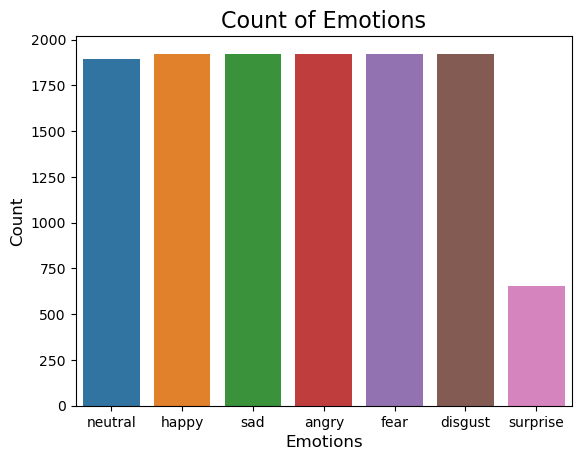

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

In [11]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
data,sr = librosa.load(file_path[0])
sr

22050

In [13]:
ipd.Audio(data,rate=sr)

In [14]:
data

array([0.03548561, 0.05175975, 0.0457577 , ..., 0.04195745, 0.04038322,
       0.04235241], dtype=float32)

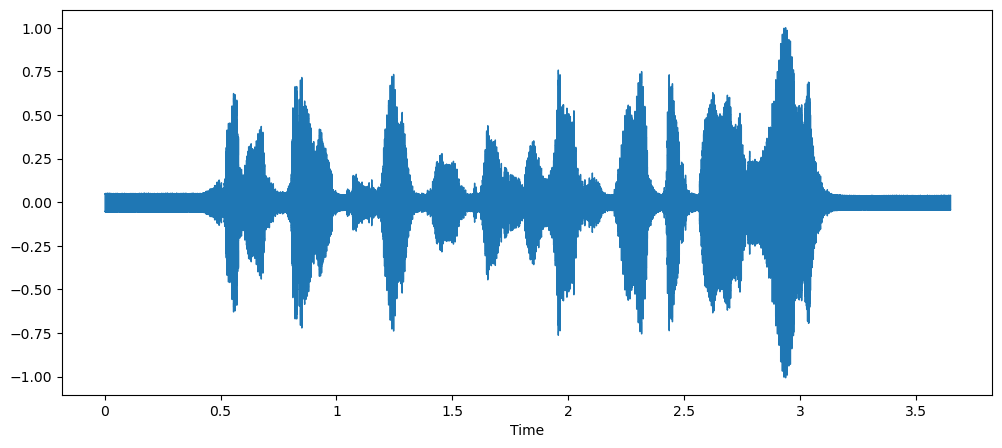

In [15]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

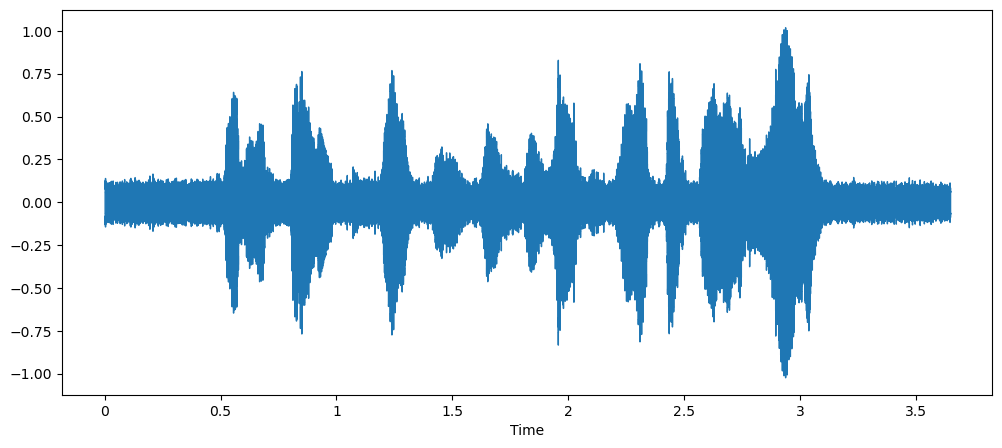

In [16]:
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

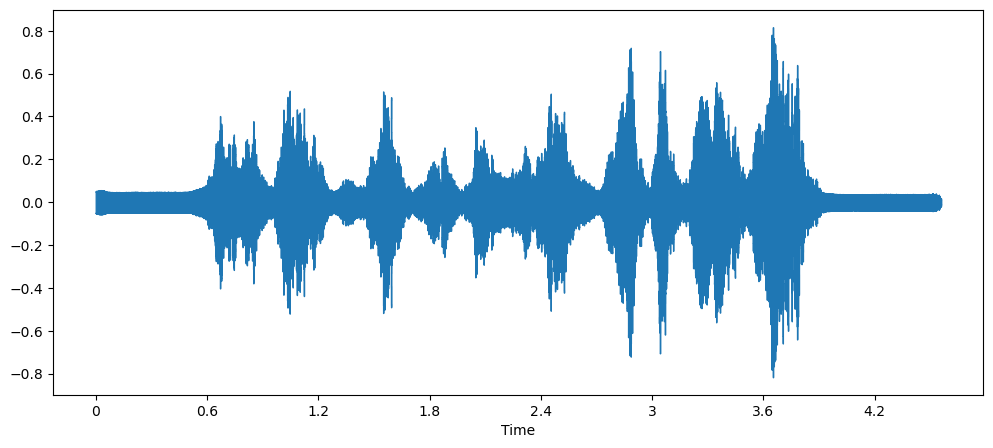

In [17]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

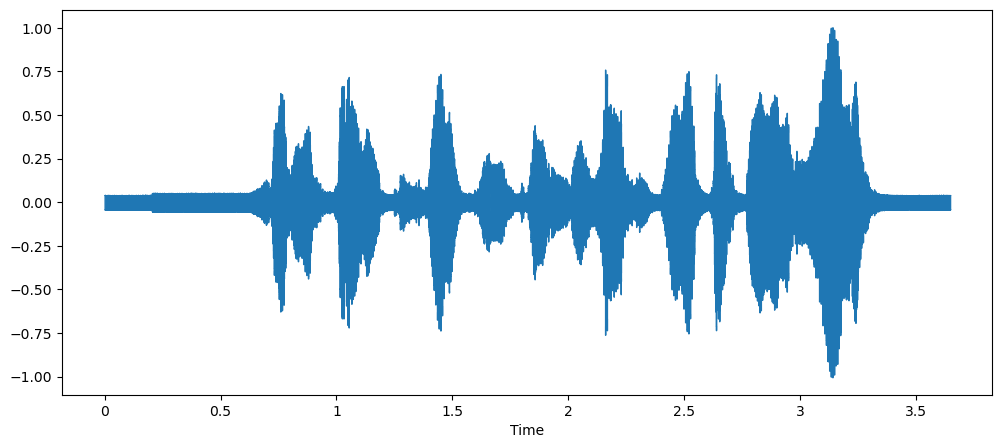

In [18]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [59]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [22]:
Emotions=pd.read_csv('speech recognition features/emotion (4).csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.251953,0.373535,0.494141,0.501465,0.482910,0.482422,0.476562,0.463379,0.469238,0.466309,...,-1.614816,-3.268710,-2.181269,-4.098365,-5.258773,-5.286760,-6.192348,-1.996428,2.875362,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518934,0.839123,1.308966,1.855113,2.404974,2.896071,3.282975,3.541090,3.666844,surprise
3,0.261719,0.388672,0.513184,0.509277,0.500977,0.496582,0.486816,0.487793,0.479980,0.491699,...,-1.774671,-1.750296,1.640066,1.664761,0.510230,1.624107,0.165312,-0.924339,-2.566185,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585885,2.746578,2.223155,0.986784,-0.730885,-2.531058,-4.002847,-4.849191,-4.929410,neutral


In [23]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [24]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [25]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [26]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [27]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [29]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [31]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [32]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_traincnn.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                    │ (None, 2376, 512)             │       3,072 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization                │ (None, 2376, 512)             │       2,048 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling1d (MaxPooling1D)       │ (None, 1188, 512)             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_1 (Conv1D)                  │ (None, 1188, 512)             │   1,311,232 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_1              │ (None, 1188, 512)             │       2,048 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling1d_1 (MaxPooling1D)     │ (None, 594, 512)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 594, 512)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_2 (Conv1D)                  │ (None, 594, 256)              │     655,616 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_2              │ (None, 594, 256)              │       1,024 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling1d_2 (MaxPooling1D)     │ (None, 297, 256)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_3 (Conv1D)                  │ (None, 297, 256)              │     196,864 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_3              │ (None, 297, 256)              │       1,024 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling1d_3 (MaxPooling1D)     │ (None, 149, 256)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 149, 256)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_4 (Conv1D)                  │ (None, 149, 128)              │      98,432 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_4              │ (None, 149, 128)              │         512 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling1d_4 (MaxPooling1D)     │ (None, 75, 128)               │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_2 (Dropout)                │ (None, 75, 128)               │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten (Flatten)                  │ (None, 9600)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 512)                   │   4,915,712 │
├────

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [37]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [38]:
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [32]:
history=model.fit(np.array(x_traincnn), y_train, epochs=12, validation_data=(x_testcnn, y_test),verbose = 1, batch_size=128)

Epoch 1/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 7385s 24s/step - accuracy: 0.4066 - loss: 1.7193 - val_accuracy: 0.2453 - val_loss: 2.1264
Epoch 2/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 6110s 20s/step - accuracy: 0.5579 - loss: 1.1464 - val_accuracy: 0.4747 - val_loss: 1.5995
Epoch 3/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 7388s 24s/step - accuracy: 0.5993 - loss: 1.0434 - val_accuracy: 0.5458 - val_loss: 1.1773
Epoch 4/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 50614s 166s/step - accuracy: 0.6304 - loss: 0.9657 - val_accuracy: 0.5898 - val_loss: 1.1038
Epoch 5/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 33015s 109s/step - accuracy: 0.6730 - loss: 0.8513 - val_accuracy: 0.5974 - val_loss: 1.0781
Epoch 6/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 17903s 59s/step - accuracy: 0.6688 - loss: 0.8831 - val_accuracy: 0.6793 - val_loss: 0.8510
Epoch 7/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 31230s 103s/step - accuracy: 0.7622 - loss: 0.6392 - val_accuracy: 0.7329 - val_loss: 0.7234
Epoch 8/12
305/305 ━━━━━━━━━━━━━━━━━━━━ 28697s 94s/step - accuracy: 0.8334 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 225s 737ms/step - accuracy: 0.8571 - loss: 0.4175
Accuracy of our model on test data :  85.31346321105957 %


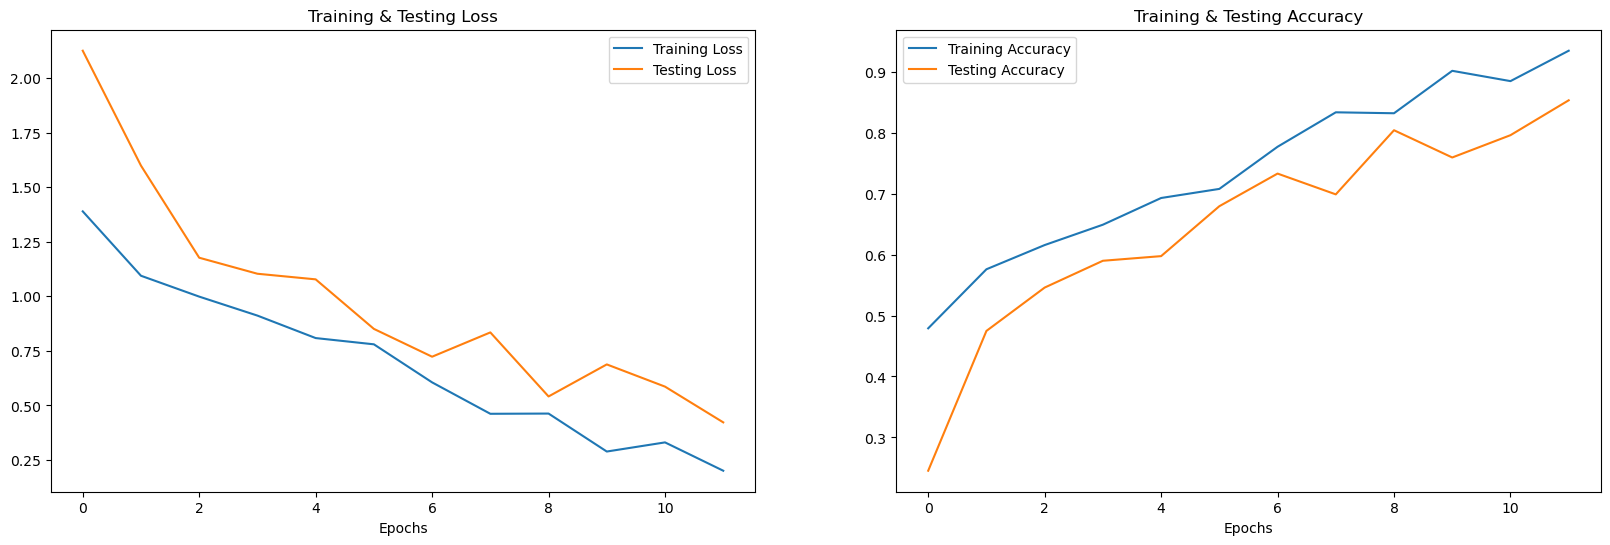

In [35]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [36]:
model.save("model.h5")

In [37]:
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

df0 = pd.DataFrame(columns = ['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()
df0.head()

305/305 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step


,Predicted Labels,Actual Labels
0,surprise,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear


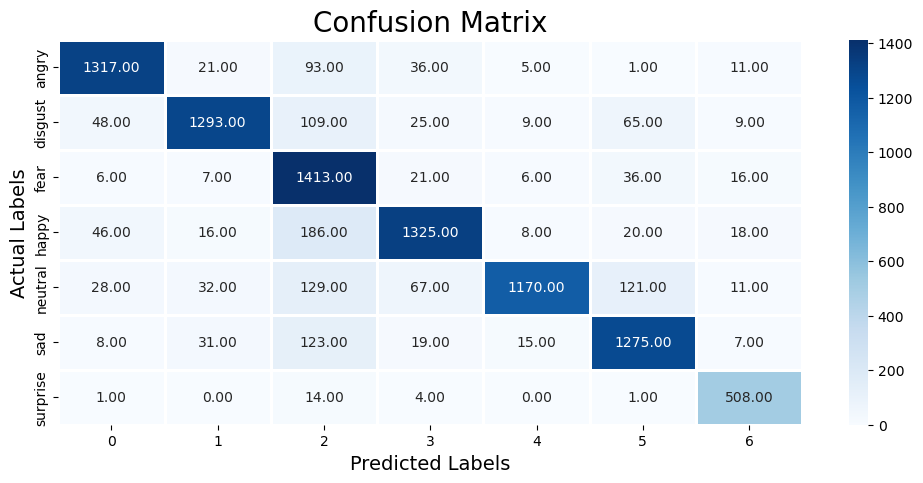

              precision    recall  f1-score   support

       angry       0.91      0.89      0.90      1484
     disgust       0.92      0.83      0.87      1558
        fear       0.68      0.94      0.79      1505
       happy       0.89      0.82      0.85      1619
     neutral       0.96      0.75      0.84      1558
         sad       0.84      0.86      0.85      1478
    surprise       0.88      0.96      0.92       528

    accuracy                           0.85      9730
   macro avg       0.87      0.86      0.86      9730
weighted avg       0.87      0.85      0.85      9730



In [39]:
cm = confusion_matrix(y_test0,y_pred0)
plt.figure(figsize = (12,5))
cm = pd.DataFrame(cm, index = [i for i in  encoder.categories_])
sns.heatmap(cm , linecolor = 'white', cmap = "Blues", linewidth = 1, annot = True, fmt = '.2f')
plt.title('Confusion Matrix', size = 20)
plt.xlabel('Predicted Labels', size = 14)
plt.ylabel('Actual Labels', size = 14)
plt.show()
print(classification_report(y_test0,y_pred0))

In [54]:
def get_predict_feat(path):
    d,sr=librosa.load(path,duration=2.5,offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    if(result.shape != 2376):
        elements_to_add = 2376 - len(result)
        additional_elements = np.random.rand(elements_to_add)
        result = np.append(result, additional_elements)
    result = np.reshape(result,newshape = (1,2376))
    i_result = scaler.transform(result)
    final_result = np.expand_dims(i_result, axis = 2)
    return final_result

In [55]:
emotions1 = {1:'Neutral', 2:'Calm',3:'Happy',4:'Sad',5:'Angry',6:"Fear",7:'Disgust',8:'Surprise'}
def prediction(path1):
    res = get_predict_feat(path1)
    predictions = model.predict(res)
    y_pred = encoder.inverse_transform(predictions)
    print(y_pred[0][0])

In [60]:
file_path = r"C:\Users\utkar\OneDrive\Desktop\SER\CREMA-D\AudioWAV\1001_DFA_NEU_XX.wav"
data, sr = librosa.load(file_path)
prediction(file_path)
ipd.Audio(data,rate = sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
neutral


In [61]:
file_path = r"C:\Users\utkar\OneDrive\Desktop\SER\Toronto emotional speech set (TESS)\TESS Toronto emotional speech set data\OAF_disgust\OAF_yearn_disgust.wav"
data, sr = librosa.load(file_path)
prediction(file_path)
ipd.Audio(data,rate = sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
disgust


In [63]:
file_path = r"C:\Users\utkar\OneDrive\Desktop\SER\New recording 1.wav"
data, sr = librosa.load(file_path)
prediction(file_path)
ipd.Audio(data,rate = sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
fear
